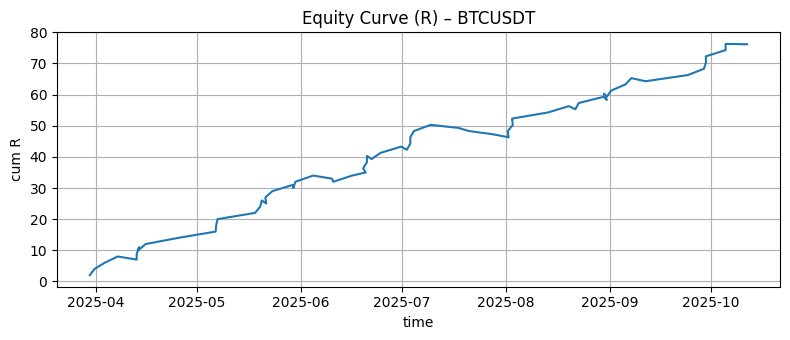

In [2]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve()
if ROOT.name == "research":
    ROOT = ROOT.parents[0]
CHAN = ROOT / "chan_data"
OUT  = CHAN / "signals" / "backtest" / "_summary"
OUT.mkdir(parents=True, exist_ok=True)

symbols = ["BTCUSDT", "ETHUSDT"]

def read_trades(sym: str) -> pd.DataFrame:
    p = CHAN / "signals" / "backtest" / sym / "trades.csv"
    df = pd.read_csv(p, parse_dates=["ts_signal","ts_entry","ts_exit"])
    for c in ["ts_signal","ts_entry","ts_exit"]:
        df[c] = pd.to_datetime(df[c], utc=True, errors="coerce")
    df["symbol"] = sym
    for c in ["r","ret_pct","score_final"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.sort_values("ts_entry").reset_index(drop=True)

def max_drawdown_R(r: pd.Series) -> float:
    eq = r.cumsum()
    dd = (eq.cummax() - eq)
    return float(dd.max()) if len(dd) else 0.0

dfs = [read_trades(s) for s in symbols]
trades = pd.concat(dfs, ignore_index=True)


rows = []
for s in symbols:
    d = trades[trades.symbol==s]
    n = len(d)
    wins = d["r"] > 0
    rows.append(dict(
        symbol=s,
        n_trades=n,
        win_pct=round(100*wins.mean(), 2),
        avgR_per_trade=round(d["r"].mean(), 3),
        avgW=round(d.loc[wins,"r"].mean(), 3) if wins.any() else np.nan,
        avgL=round(d.loc[~wins,"r"].mean(), 3) if (~wins).any() else np.nan,
        maxDD_R=round(max_drawdown_R(d["r"]), 2),
    ))
summary_df = pd.DataFrame(rows)

for c in ["tf","side","tag","symbol"]:
    if c not in trades.columns: trades[c] = pd.NA
bucket = (trades
          .groupby(["symbol","tf","side","tag"], dropna=False)
          .agg(n=("r","size"),
               win_pct=("r", lambda x: 100*(x>0).mean()),
               avgR=("r","mean"),
               avgW=("r", lambda x: x[x>0].mean() if (x>0).any() else np.nan),
               avgL=("r", lambda x: x[x<=0].mean() if (x<=0).any() else np.nan))
          .reset_index()
          .sort_values(["symbol","n","avgR"], ascending=[True,False,False]))
bucket = bucket[bucket["n"]>=5].reset_index(drop=True)
bucket.to_csv(OUT/"bucket_stats_tf_side_tag.csv", index=False)
bucket

for s in symbols:
    d = trades[trades.symbol==s].copy()
    if d.empty: continue
    eq = d["r"].cumsum()
    plt.figure(figsize=(8,3.5))
    plt.plot(d["ts_exit"], eq)
    plt.title(f"Equity Curve (R) – {s}")
    plt.xlabel("time"); plt.ylabel("cum R")
    plt.grid(True); plt.tight_layout()
    plt.show()


In [1]:
import pandas as pd, numpy as np
from pathlib import Path

ROOT = Path.cwd().resolve()
if ROOT.name == "research":
    ROOT = ROOT.parents[0]
CHAN = ROOT / "chan_data"

symbols = ["BTCUSDT","ETHUSDT"]

def read_trades(sym):
    p = CHAN / "signals" / "backtest" / sym / "trades.csv"
    df = pd.read_csv(p, parse_dates=["ts_signal","ts_entry","ts_exit"])
    df["symbol"] = sym
    return df

def max_drawdown_R(r_series: pd.Series) -> float:
    eq = r_series.fillna(0).cumsum()
    peak = eq.cummax()
    dd = (eq - peak)
    return float(-dd.min()) if len(dd) else 0.0


dfs = [read_trades(s) for s in symbols]
trades = pd.concat(dfs, ignore_index=True)

rows = []
for s in symbols:
    d = trades[trades.symbol==s].copy()
    n = len(d)
    wins = d["r"] > 0
    rows.append({
        "Symbol": s,
        "Trades": n,
        "Win Rate": f"{wins.mean()*100:.2f}%",
        "Avg R / Trade": f"{d['r'].mean():.2f}",
        "Avg R (Winners)": f"{d.loc[wins,'r'].mean():.2f}" if wins.any() else "—",
        "Avg R (Losers)": f"{d.loc[~wins,'r'].mean():.2f}" if (~wins).any() else "—",
        "Max Drawdown (R)": f"{max_drawdown_R(d['r']):.2f}",
    })

summary_df = pd.DataFrame(rows)

summary_df.style.set_properties(**{"text-align":"center"}) \
    .set_table_styles([{"selector":"th","props":[("text-align","center")]}]) \
    .hide(axis="index")


In [4]:
TOP_N = 12

bucket = (trades
          .groupby(["symbol","tf","side","tag"], dropna=False)["r"]
          .size()
          .reset_index(name="Count"))


bucket_top = (bucket
              .sort_values(["symbol","Count"], ascending=[True, False])
              .groupby("symbol")
              .head(TOP_N)
              .reset_index(drop=True))


bucket_top.style.hide(axis="index") \
    .set_properties(**{"text-align":"center"}) \
    .set_table_styles([{"selector":"th","props":[("text-align","center")]}])
